<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/Taxa_de_crescimento_de_estruturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos plotar a função taxa de crescimento de estruturas $f$ e como seu comportamento varia de acordo com os parâmetros: $w_0$, $\Omega_{k0}$,  $\Omega_{m0}$ e $w_a$. 

In [1]:
# Bibliotecas:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pyccl']

conda-forge/linux-64                                        Usin

In [3]:
import pyccl as ccl

A seguir, temos os 11 dados de $f$ e $z$ retirados de https://arxiv.org/pdf/2201.07829.pdf e que serão colocados nas curvas de degenerescência entre dois parâmetros.

In [4]:
f_dados = np.array([0.56, 0.49, 0.49, 0.60, 0.70, 0.66, 0.70, 0.75, 0.73, 0.91, 0.90])
f_erro = np.array([0.07, 0.14, 0.12, 0.10, 0.18, 0.09, 0.07, 0.18, 0.07, 0.36, 0.24])
z_dados = np.array([0.013, 0.15, 0.18, 0.22, 0.35, 0.38, 0.41, 0.55, 0.60, 0.77, 1.40])

Primeiramente, manteremos os valores de $\Omega_{k0}$ e $\Omega_{m0}$ fixos de acordo com os valores obtidos pelo Planck e iremos variar $w_0$ entre -1.2 e -0.8 (lembrando que no modelo $\Lambda$CDM temos que $w_0$ = -1).

Lembrando que:

$\Omega_m (a) = \frac{\Omega_{m0} a^{-3}}{\Omega_{m0} a^{-3} + \Omega_{k0} a^{-2} + \Omega_{\Lambda 0}}$,

em que:

$\Omega_{\Lambda 0} = 1 - \Omega_{m0}$.

Logo:

$\Omega_m (a) = \frac{\Omega_{m0} a^{-3}}{\Omega_{m0} a^{-3} + \Omega_{k0} a^{-2} + 1 - \Omega_{m0}}$.

Então, neste primeiro caso consideraremos $\Omega_{m0}$ = 0.30 e $\Omega_{k0}$ = 0.

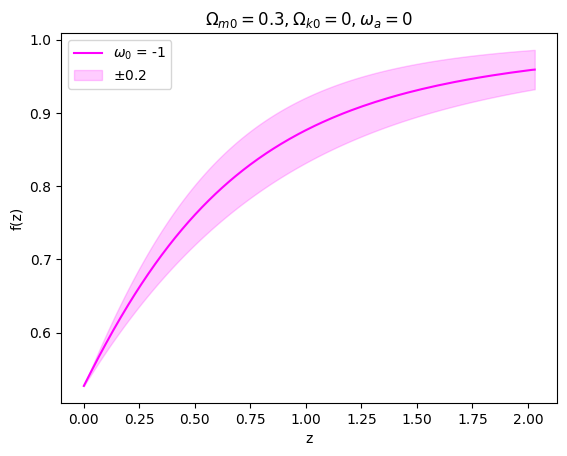

In [5]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30

# definindo O_m
#Om = (Om0*(a**(-3)))/(Om0*(a**(-3)) + 1 - Om0)

# definindo w0
w0 = -1
sigw0 = 0.2

# definindo gamma
gamma = 6./11.

# definindo o erro de f
f_1 = (Om0*((1 + z)**3))/( Om0*((1 + z)**3) + ( 1 - Om0 )*( (1 + z)**(3*(1+w0)) ) )
f_2 = (1 - Om0)*( (1+z)**(3*(1 + w0)) ) + Om0*((1 + z)**3)
df = ( (3*(Om0 - 1)*Om0*gamma*((1+z)**(3*(1+w0) + 3))*np.log(1+z) )/(f_2)**2)*((f_1)**(gamma-1))
sig_f = ((df)*sigw0)

fig, ax = plt.subplots()
ax.plot(z, f, label='$\omega_0$ = -1', color='magenta')
plt.xlabel('z')
plt.ylabel('f(z)')
ax.fill_between(z, f - sig_f, f + sig_f, alpha=0.2, label='$\pm$0.2', color='magenta')
plt.legend(loc='upper left')
plt.title('$\Omega_{m0} = 0.3, \Omega_{k0} = 0, \omega_a = 0$')
plt.show()

Agora, vamos manter $w_0$ e $\Omega_{k0}$ fixos em -1 e 0, respectivamente, e variar $\Omega_{m0}$ entre 0.25 e 0.35

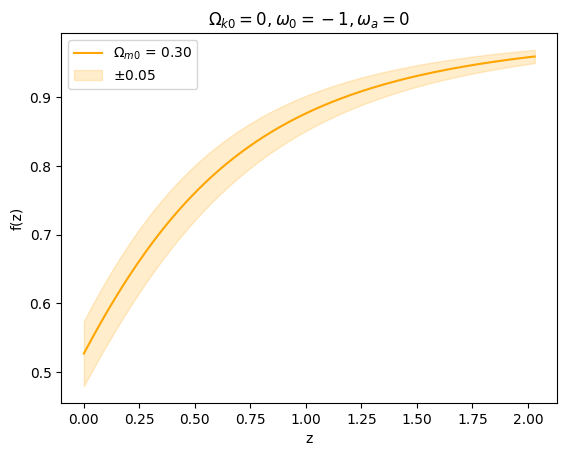

In [6]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30

# definindo O_m
#Om = (Om0*(a**(-3)))/(Om0*(a**(-3)) + 1 - Om0)
sigOm0 = 0.05

# definindo w0
w0 = -1

# definindo gamma
gamma = 6./11.

# definindo o erro de f
df1 = gamma*( ((1+z)**3)/f_2 - ( ((1+z)**3)*Om0*( ((1+z)**3) -  (1+z)**(3*(1 + w0)) ) )/( (f_2)**2) )*( (f_1)**(gamma-1) )
sig_f1 = ((df1)*sigOm0)

fig, ax = plt.subplots()
ax.plot(z, f, label='$\Omega_{m0}$ = 0.30', color='orange')
plt.xlabel('z')
plt.ylabel('f(z)')
ax.fill_between(z, f - sig_f1, f + sig_f1, alpha=0.2, color='orange', label='$\pm$0.05')
plt.legend(loc='upper left')
plt.title('$\Omega_{k0} = 0, \omega_0 = -1, \omega_a = 0$')
plt.show()

Faremos um gráfico com os valores do modelo $\Lambda$CDM com as variações para $\Omega_{m0}$ e $\omega_0$ escolhidas: $\pm$ 0.05 e $\pm$ 0.2, respectivamente.

0.25640993263317685
-0.7952874891952177


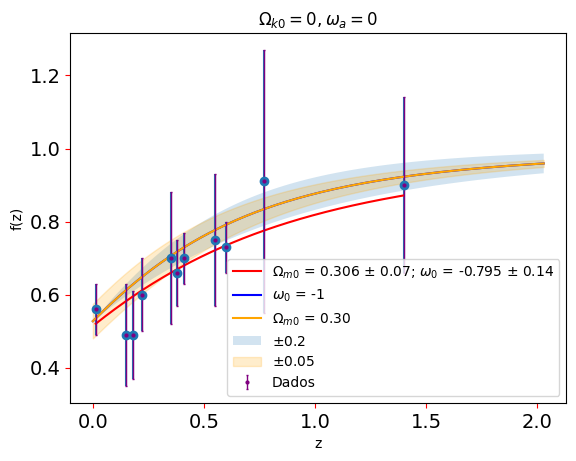

In [7]:
# definindo a função f para o caso de Om e w0 variando

def f1_teorico(z, Om_c, w0):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    a = 1/(1+z)

    return ccl.background.growth_rate(cosmo, a)


# ajuste da função

popt, pcov = curve_fit(f1_teorico, z_dados, f_dados, sigma=f_erro, p0=[0.25,-1.2], bounds=([-1.5, -1.5], [1., 1.]), method='trf')
print(popt[0])
print(popt[1])

p1 = popt[0] + 0.049411603
p2 = popt[1]

erro = f_erro
e1 = erro[0]
e2 = erro[1]

# plote

#best-fit
zi = np.linspace(min(z_dados), max(z_dados), 1000)

fig, ax = plt.subplots()
plt.tick_params(labelsize=14, color='red')
plt.errorbar(z_dados, f_dados, f_erro, fmt='o')
plt.plot(zi, f1_teorico(zi, popt[0], popt[1]), color='red', label=r'$\Omega_{m0}$ = '+str(np.round(p1, 3))+' $\pm$ '+str(np.round(e1, 4))+'; '+'$\omega_0$ = '+str(np.round(p2, 3))+' $\pm$ '+str(np.round(e2, 4)))

#curvas e dados
ax.plot(z, f, label='$\omega_0$ = -1', color='blue')
ax.plot(z, f, label='$\Omega_{m0}$ = 0.30', color='orange')
plt.errorbar(z_dados, f_dados, yerr = f_erro, color = 'purple', label='Dados', fmt='o', markersize=2, elinewidth=1, capsize=1)

# área sombreada
ax.fill_between(z, f - sig_f, f + sig_f, alpha=0.2, label='$\pm$0.2')
ax.fill_between(z, f - sig_f1, f + sig_f1, alpha=0.2, color='orange', label='$\pm$0.05')

# legenda, título e eixos
plt.legend(loc='best')
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('$\Omega_{k0} = 0, \omega_a = 0$')
plt.show()

In [8]:
!pip install derivative
from derivative import dxdt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 26.4 MB/s eta 0:00:00


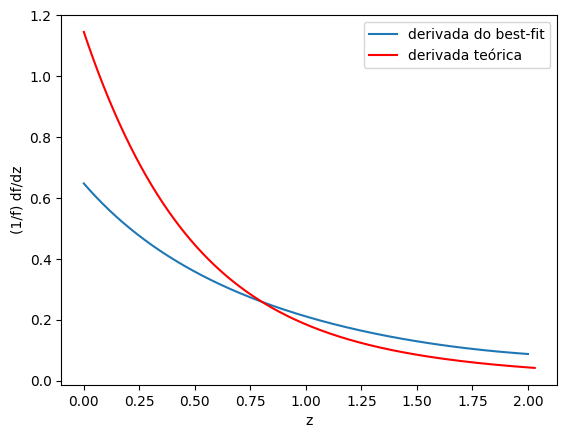

In [9]:
zi = np.linspace(min(z_dados), max(z_dados), 1000)

def f11_teorico(z, Om_c, w0):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    ai = 1/(1+zi)

    return ccl.background.growth_rate(cosmo, ai)

# derivada usando cubic spline

x1 = np.linspace(0, 2.0, 1000)
y1 = f11_teorico(zi, *popt)

# 4. Spline derivative with smoothing set to 0.01
result4 = dxdt(y1, x1, kind="spline", s=1e-2)
derivada_bf = result4/f11_teorico(zi, *popt)

# derivada teórica
gamma = 6/11
Om0 = 0.30
O_L0 = 1 - Om0

derivada_teo = ( (3 * gamma * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) ) * f

plt.plot(x1, derivada_bf, label='derivada do best-fit')
plt.plot(z, derivada_teo/f, label='derivada teórica', color='red')

# legenda, título e eixos
plt.ylabel('(1/f) df/dz')
plt.xlabel('z')
plt.legend()
plt.show()

In [11]:
# cálculo do xi2 reduzido: quanto mais próximo de 1, maior a concordância entre as distribuições observadas e esperadas

xi2 = np.sum(( (f_dados - f1_teorico(z_dados, *popt)) / f_erro) ** 2)
df = len(z) - 2
print(xi2/df)

0.001872680971747683


Agora, vamos manter $w_0$ e $\Omega_{m0}$ fixos em -1 e 0.30, respectivamente, e variar $\Omega_{k0}$ entre -0.1 e 0.1.

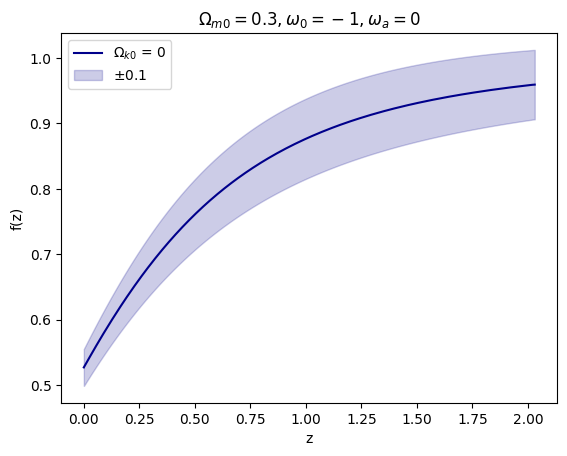

In [12]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30
Ok0 = 0
OL0 = 0.70

# definindo O_m
#Om = ( Om0*(a**(-3)) )/( Om0*(a**(-3)) + OL0 + Ok0*(a**(-2)) )

# definindo o erro de O_k0
sigOk0 = 0.1

# definindo w0
w0 = -1

# definindo gamma
gamma = 6./11.

# definindo o erro de f
f_3 = ( Om0*( (1+z)**3 ))/( Om0*( (1+z)**3 ) + Ok0*( (1+z)**2 ) + OL0)
df3 = - (gamma*( (f_3)**(gamma+1) ))/( Om0*(1+z))
sig_f3 = ((df3)*sigOk0)

fig, ax = plt.subplots()
ax.plot(z, f, label='$\Omega_{k0}$ = 0', color='darkblue')
plt.xlabel('z')
plt.ylabel('f(z)')
ax.fill_between(z, f - sig_f3,  f + sig_f3,  alpha=0.2, color='darkblue', label='$\pm$0.1')
plt.legend(loc='upper left')
plt.title('$\Omega_{m0} = 0.3, \omega_0 = -1, \omega_a = 0$')
plt.show()

Faremos um gráfico com os valores do modelo $\Lambda$CDM com as variações para $\Omega_{k0}$ e $\omega_0$ escolhidas: $\pm$ 0.1 e $\pm$ 0.2, respectivamente.

-0.9999999999999488
-0.48157483475057244


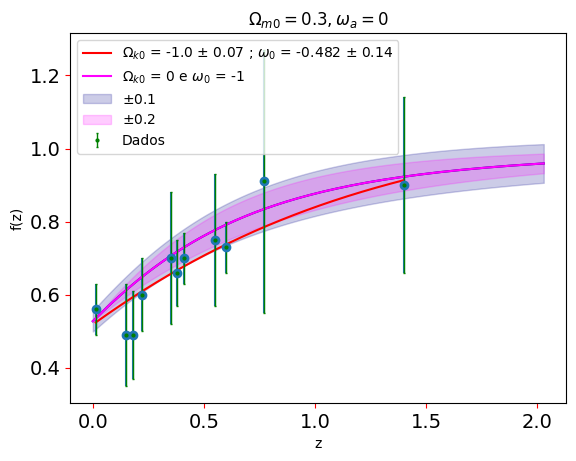

In [13]:
# definindo a função f para o caso de Om e w0 variando

def f2_teorico(z, Om_k, w0):

    cosmo = ccl.Cosmology(Omega_c=0.26, h=0.6727, Omega_b=0.049411603, Omega_k=Om_k, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    a = 1/(1+z)

    return ccl.background.growth_rate(cosmo, a)


# ajuste da função

popt, pcov = curve_fit(f2_teorico, z_dados, f_dados, sigma=f_erro, p0=[-0.1,-1], bounds=([-1, -1], [1., 1.]), method='trf')
print(popt[0])
print(popt[1])

p1 = popt[0]
p2 = popt[1]

erro = f_erro
e1 = erro[0]
e2 = erro[1]

# plote

#best-fit
zi = np.linspace(min(z_dados), max(z_dados), 1000)

fig, ax = plt.subplots()
plt.tick_params(labelsize=14, color='red')
plt.errorbar(z_dados, f_dados, f_erro, fmt='o')
plt.plot(zi, f2_teorico(zi, popt[0], popt[1]), color='red', label=r'$\Omega_{k0}$ = '+str(np.round(p1, 3))+' $\pm$ '+str(np.round(e1, 4))+' ; '+'$\omega_0$ = '+str(np.round(p2, 3))+' $\pm$ '+str(np.round(e2, 4)))

#curvas e dados
ax.plot(z, f, color='darkblue')
ax.plot(z, f, label='$\Omega_{k0}$ = 0 e $\omega_0$ = -1', color='magenta')
plt.errorbar(z_dados, f_dados, yerr = f_erro, color = 'green', label='Dados', fmt='o', markersize=2, elinewidth=1, capsize=1)

# região sombreada
ax.fill_between(z, f - sig_f3,  f + sig_f3,  alpha=0.2, color='darkblue', label='$\pm$0.1')
ax.fill_between(z, f - sig_f, f + sig_f, alpha=0.2, label='$\pm$0.2', color='magenta')

# legenda, título e label
plt.xlabel('z')
plt.ylabel('f(z)')
plt.legend(loc='best')
plt.title('$\Omega_{m0} = 0.3, \omega_a = 0$')
plt.show()

In [14]:
# cálculo do xi2 reduzido: quanto mais próximo de 1, maior a concordância entre as distribuições observadas e esperadas

xi22 = np.sum(( (f_dados - f2_teorico(z_dados, *popt)) / f_erro) ** 2)
df = len(z) - 2
print(xi22/df)

0.0017665485937600103


Vamos fazer uma figura com os valores de $\Omega_{m0}$ e $\Omega_{k0}$ do modelo $\Lambda$CDM e as variações escolhidas anteriormente: $\pm$ 0.05 e $\pm$ 0.1, respectivamente.

0.2498278642756098
0.12237839858233161


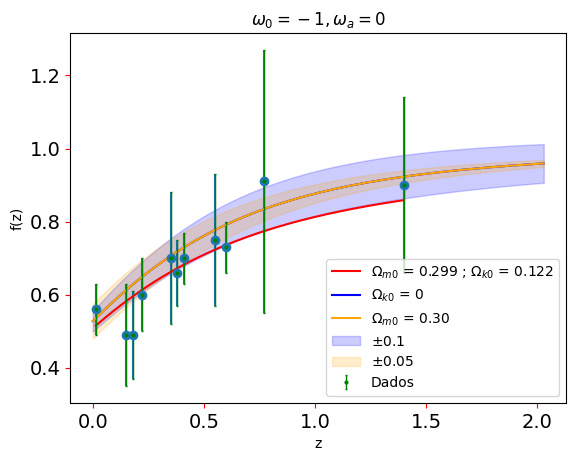

In [15]:
# definindo a função f para o caso de Om e w0 variando

def f3_teorico(z, Om_c, Om_k):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=Om_k, w0=-1, wa=0, sigma8=0.8120, n_s=0.9649)

    a = 1/(1+z)

    return ccl.background.growth_rate(cosmo, a)


# ajuste da função

popt, pcov = curve_fit(f3_teorico, z_dados, f_dados, sigma=f_erro, p0=[0.25,-0.1], bounds=([-1, -1.], [1., 1.]), method='trf')
print(popt[0])
print(popt[1])

p1 = popt[0] + 0.049411603
p2 = popt[1]

# plote

#best-fit
zi = np.linspace(min(z_dados), max(z_dados), 1000)

fig, ax = plt.subplots()
plt.tick_params(labelsize=14, color='red')
plt.errorbar(z_dados, f_dados, f_erro, fmt='o')
plt.plot(zi, f3_teorico(zi, popt[0], popt[1]), color='red', label=r'$\Omega_{m0}$ = '+str(np.round(p1, 3))+' ; '+'$\Omega_{k0}$ = '+str(np.round(p2, 3)))

# curvas e dados
ax.plot(z, f, label='$\Omega_{k0}$ = 0', color='blue')
ax.plot(z, f, label='$\Omega_{m0}$ = 0.30', color='orange')
plt.errorbar(z_dados, f_dados, yerr = f_erro, color = 'green', label='Dados', fmt='o', markersize=2, elinewidth=1, capsize=1)

# regiões sombreadas
ax.fill_between(z, f - sig_f3, f + sig_f3, alpha=0.2, color='blue', label='$\pm$0.1')
ax.fill_between(z, f - sig_f1, f + sig_f1, alpha=0.2, color='orange', label='$\pm$0.05')

# legenda, título e label
plt.xlabel('z')
plt.ylabel('f(z)')
plt.legend(loc='best')
plt.title('$\omega_0 = -1, \omega_a = 0$')
plt.show()

Consideremos agora outro intervalo de variação para $\Omega_{k0}$: $\pm$ 0.05, mantendo a mesma variação para $\Omega_{m0}$.

0.24982827514052697
0.12238000740009568


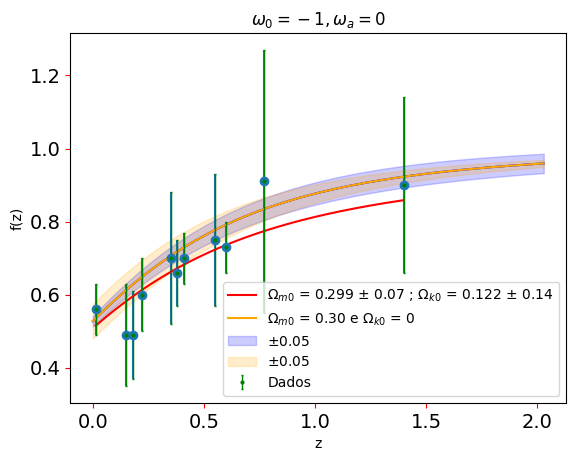

In [16]:
# definindo o novo erro de O_k0
sigOk0_1 = 0.05

# definindo o erro de f
f_3 = ( Om0*( (1+z)**3 ))/( Om0*( (1+z)**3 ) + Ok0*( (1+z)**2 ) + OL0)
df3 = - (gamma*( (f_3)**(gamma+1) ))/( Om0*(1+z))
sig_f3new = ((df3)*sigOk0_1)

# definindo a função f para o caso de Om e w0 variando

def f3_teorico(z, Om_c, Om_k):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=Om_k, w0=-1, wa=0, sigma8=0.8120, n_s=0.9649)

    a = 1/(1+z)

    return ccl.background.growth_rate(cosmo, a)


# ajuste da função

popt, pcov = curve_fit(f3_teorico, z_dados, f_dados, sigma=f_erro, p0=[0.25,-0.05], bounds=([-1, -1.], [1., 1.]), method='trf')
print(popt[0])
print(popt[1])

p1 = popt[0] + 0.049411603
p2 = popt[1]

erro = f_erro
e1 = erro[0]
e2 = erro[1]

# plote

#best-fit
zi = np.linspace(min(z_dados), max(z_dados), 1000)

fig, ax = plt.subplots()
plt.tick_params(labelsize=14, color='red')
plt.errorbar(z_dados, f_dados, f_erro, fmt='o')
plt.plot(zi, f3_teorico(zi, popt[0], popt[1]), color='red', label=r'$\Omega_{m0}$ = '+str(np.round(p1, 3))+' $\pm$ '+str(np.round(e1, 4))+' ; '+'$\Omega_{k0}$ = '+str(np.round(p2, 3))+' $\pm$ '+str(np.round(e2, 4)))

# curvas e dados
ax.plot(z, f, color='blue')
ax.plot(z, f, label='$\Omega_{m0}$ = 0.30 e $\Omega_{k0}$ = 0', color='orange')
plt.errorbar(z_dados, f_dados, yerr = f_erro, color = 'green', label='Dados', fmt='o', markersize=2, elinewidth=1, capsize=1)

# região sombreada
ax.fill_between(z, f - sig_f3new, f + sig_f3new, alpha=0.2, color='blue', label='$\pm$0.05')
ax.fill_between(z, f - sig_f1, f + sig_f1, alpha=0.2, color='orange', label='$\pm$0.05')

# legenda, título e label
plt.xlabel('z')
plt.ylabel('f(z)')
plt.legend(loc='best')
plt.title('$\omega_0 = -1, \omega_a = 0$')
plt.show()

In [17]:
# cálculo do xi2 reduzido: quanto mais próximo de 1, maior a concordância entre as distribuições observadas e esperadas

xi23 = np.sum(( (f_dados - f3_teorico(z_dados, *popt)) / f_erro) ** 2)
df = len(z) - 2
print(xi23/df)

0.001968299024815745


Por fim, vamos manter $w_0$, $\Omega_{m0}$ e $\Omega_{k0}$ fixos em -1, 0.30 e 0, respectivamente. Porém, iremos considerar que a equação de estado é dada por:

$\omega = \omega_0 + \omega_a (1 - a)$,

e variaremos $\omega_a$ entre -0.1 e 0.3.

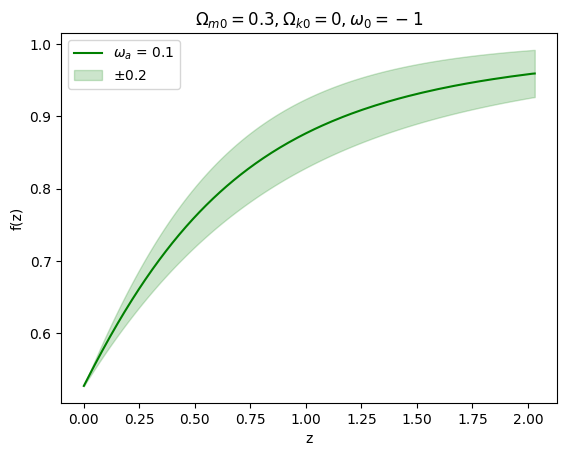

In [18]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30

# definindo w0 e w
w0 = -1
w_a = 0.1
w = w0 + (w_a * (1-a))
sigwa = 0.2

# definindo gamma
gamma = 6./11.

# definindo o erro de f
f_4 = (Om0*((1 + z)**3))/( Om0*((1 + z)**3) + ( 1 - Om0 )*( (1 + z)**(3*(1+w)) ) )
f_5 = (1 - Om0)*( (1+z)**(3*(1 + w)) ) + Om0*((1 + z)**3)
df4 = ( (3*(Om0 - 1)*Om0*gamma*((1+z)**(3*(1+w) + 3))*np.log(1+z) )/(f_5)**2)*((f_4)**(gamma-1))
sig_f4 = ((df4)*sigwa)

fig, ax = plt.subplots()
ax.plot(z, f, label='$\omega_a$ = 0.1', color='green')
plt.xlabel('z')
plt.ylabel('f(z)')
ax.fill_between(z, f - sig_f4, f + sig_f4, alpha=0.2, color='green', label='$\pm$0.2')
plt.legend(loc='upper left')
plt.title('$\Omega_{m0} = 0.3, \Omega_{k0} = 0, \omega_0 = -1$')
plt.show()

Fazendo novamente o plot considerando a expressão para $X(z)$ que se encontra na tabela 1 do artigo de Wang & Tegmark. Agora, encontramos o plot correto.

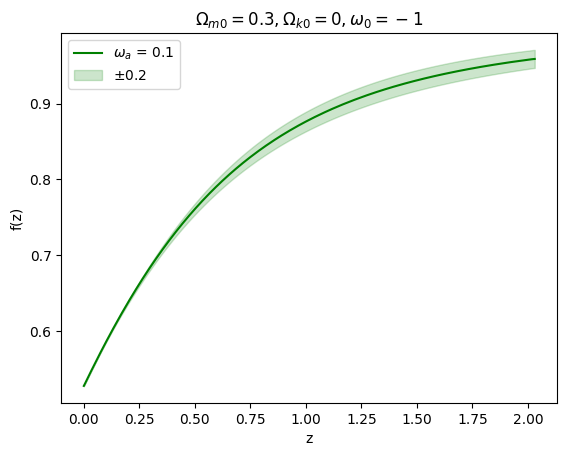

In [19]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30

# definindo w0 e w
w0 = -1
w_a = 0.1
w = w0 + (w_a * (1-a))
sigwa = 0.2

# definindo gamma
gamma = 6./11.

# definindo o erro de f
g_1 = Om0*( (np.exp(3*w_a*(a-1)))*((1+z)**(3*(w0+w_a))) - 1 ) - np.exp(3*w_a*(a-1))*((1+z)**(3*( w0 + w_a )))
g_2 = Om0/( Om0 - (Om0-1)*(np.exp(3*w_a*(a-1)))*((1+z)**(3*(w0+w_a)) ) ) 
df5 = -(( 3*(Om0-1)*gamma*(np.exp(3*w_a*(a-1)))*( np.log(1+z) + a - 1 )*((1+z)**(3*(w0+w_a))) )/g_1)*(g_2)**gamma
sig_f5 = ((df5)*sigwa)

fig, ax = plt.subplots()
ax.plot(z, f, label='$\omega_a$ = 0.1', color='green')
plt.xlabel('z')
plt.ylabel('f(z)')
ax.fill_between(z, f - sig_f5, f + sig_f5, alpha=0.2, color='green', label='$\pm$0.2')
plt.legend(loc='upper left')
plt.title('$\Omega_{m0} = 0.3, \Omega_{k0} = 0, \omega_0 = -1$')
plt.show()

Façamos agora um gráfico com os valores do modelo $\Lambda$CDM com as variações para $\omega_{0}$ e $\omega_a$ escolhidas: $\pm$ 0.1 e $\pm$ 0.2, respectivamente.

-0.5860400177785589
-1.4999999999841809


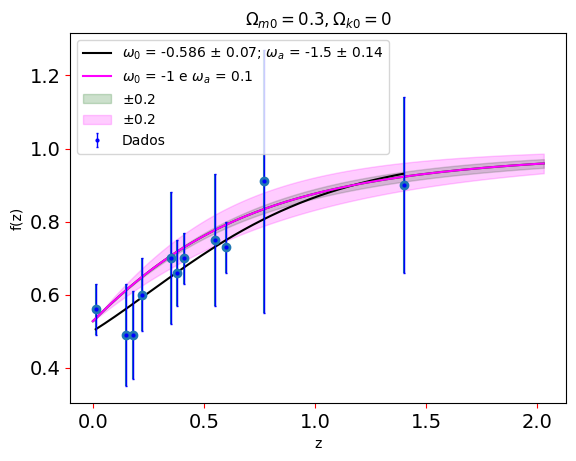

In [20]:
# definindo a função f para o caso de Om e w0 variando

def f4_teorico(z, w0, wa):

    cosmo = ccl.Cosmology(Omega_c=0.24, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=wa, sigma8=0.8120, n_s=0.9649)

    a = 1/(1+z)

    return ccl.background.growth_rate(cosmo, a)


# ajuste da função

popt, pcov = curve_fit(f4_teorico, z_dados, f_dados, sigma=f_erro, p0=[-1.1,-0.2], bounds=([-1.5, -1.5], [1., 1.]), method='trf')
print(popt[0])
print(popt[1])

p1 = popt[0]
p2 = popt[1]

erro = f_erro
e1 = erro[0]
e2 = erro[1]


# plote

#best-fit
zi = np.linspace(min(z_dados), max(z_dados), 1000)

fig, ax = plt.subplots()
plt.tick_params(labelsize=14, color='red')
plt.errorbar(z_dados, f_dados, f_erro, fmt='o')
plt.plot(zi, f4_teorico(zi, popt[0], popt[1]), color='black', label=r'$\omega_0$ = '+str(np.round(p1, 3))+' $\pm$ '+str(np.round(e1, 4))+'; '+'$\omega_a$ = '+str(np.round(p2, 3))+' $\pm$ '+str(np.round(e2, 4)))

# curvas e dados
ax.plot(z, f, color='darkgreen')
ax.plot(z, f, label='$\omega_0$ = -1 e $\omega_a$ = 0.1', color='magenta')
plt.errorbar(z_dados, f_dados, yerr = f_erro, color = 'blue', label='Dados', fmt='o', markersize=2, elinewidth=1, capsize=1)

# região sombreada
ax.fill_between(z, f - sig_f5, f + sig_f5, alpha=0.2, color='darkgreen', label='$\pm$0.2')
ax.fill_between(z, f - sig_f, f + sig_f, alpha=0.2, label='$\pm$0.2', color='magenta')

# legenda, título e label
plt.xlabel('z')
plt.ylabel('f(z)')
plt.legend(loc='best')
plt.title('$\Omega_{m0} = 0.3, \Omega_{k0} = 0$')
plt.show()

In [21]:
# cálculo do xi2 reduzido: quanto mais próximo de 1, maior a concordância entre as distribuições observadas e esperadas

xi24 = np.sum(( (f_dados - f4_teorico(z_dados, *popt)) / f_erro) ** 2)
df = len(z) - 2
print(xi24/df)

0.0017858745065598397


Por fim, faremos  um gráfico com os valores do modelo padrão com variações para 3 parâmetros: $\Omega_{m0}$, $\omega_0$ e $\omega_a$.

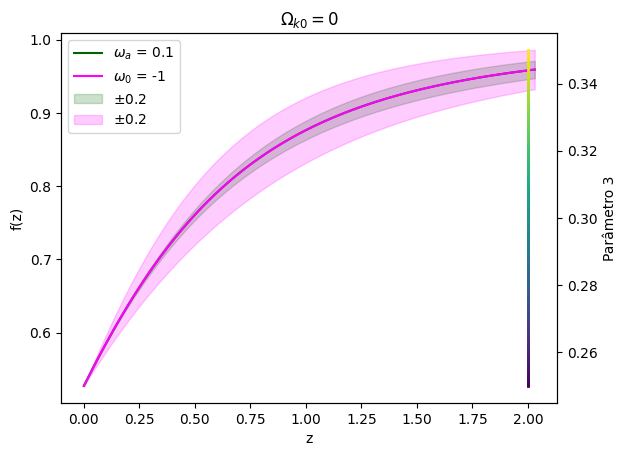

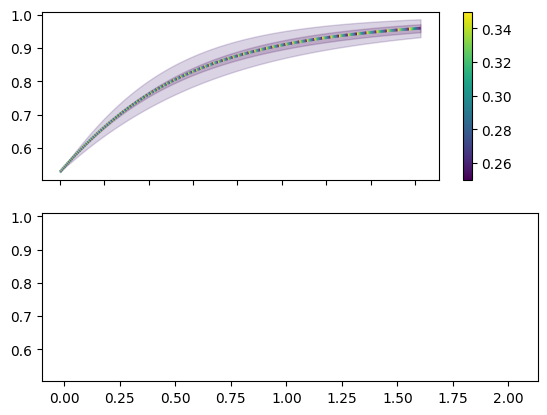

In [22]:
import matplotlib.cm as cm

fig, ax = plt.subplots()
ax.plot(z, f, label='$\omega_a$ = 0.1', color='darkgreen')
ax.plot(z, f, label='$\omega_0$ = -1', color='magenta')
#ax.plot(z, f, label='$\Omega_{m0}$ = 0.30', color='orange')
#plt.errorbar(z_dados, f_dados, yerr = f_erro, color = 'blue', label='Dados', fmt='o', markersize=2, elinewidth=1, capsize=1)
plt.xlabel('z')
plt.ylabel('f(z)')
ax.fill_between(z, f - sig_f5, f + sig_f5, alpha=0.2, color='darkgreen', label='$\pm$0.2')
ax.fill_between(z, f - sig_f, f + sig_f, alpha=0.2, label='$\pm$0.2', color='magenta')
#ax.fill_between(z, f - sig_f1, f + sig_f1, alpha=0.2, color='orange', label='$\pm$0.05')
plt.legend(loc='upper left')
plt.title('$\Omega_{k0} = 0$')

points = np.array([z, f]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

Om = np.arange(0.25, 0.36, 0.01)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(Om.min(), Om.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)

# Set the values used for colormapping
lc.set_array(Om)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Cria o eixo secundário e adiciona a linha multicolorida
ax2 = ax.twinx()
Om = np.linspace(0.25, 0.35, 1000)
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(Om)))
for i in range(len(Om)-1):
    ax2.plot([2,2], [Om[i],Om[i+1]], c=colors[i], linewidth=2)
ax2.set_ylabel('Parâmetro 3')

Om = np.arange(0.25, 0.36, 0.01)
colors = cm.viridis(norm(Om))
axs[0].fill_between(z, f - sig_f5, f + sig_f5, alpha=0.2, color=colors[0], label='$\pm$0.2')
axs[0].fill_between(z, f - sig_f, f + sig_f, alpha=0.2, color=colors[1], label='$\pm$0.2')


plt.show()

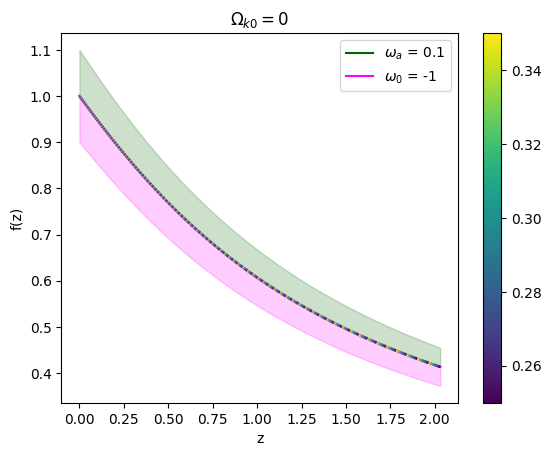

In [23]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 

a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

fig, ax = plt.subplots()

f = ccl.growth_factor(cosmo, a)

ax.plot(z, f, label='$\omega_a$ = 0.1', color='darkgreen')
ax.plot(z, f, label='$\omega_0$ = -1', color='magenta')

ax.fill_between(z, f, f*(1+0.1), color='darkgreen', alpha=0.2)
ax.fill_between(z, f, f*(1-0.1), color='magenta', alpha=0.2)

Om = np.arange(0.25, 0.36, 0.01)

points = np.array([z, f]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

norm = plt.Normalize(Om.min(), Om.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)

lc.set_array(Om)
lc.set_linewidth(2)

line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlabel('z')
ax.set_ylabel('f(z)')
ax.set_title('$\Omega_{k0} = 0$')
ax.legend()

plt.show()

(z, f): [0.1  0.2  0.25 0.3  0.4  0.5  0.6  0.7  0.75 0.8  0.9  1.   1.1  1.2
 1.25 1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.  ] [0.94836544 0.89920167 0.87565526 0.8528334  0.80940854 0.76894349
 0.7313632  0.69653373 0.68009895 0.66428749 0.63444044 0.60680515
 0.58119791 0.55744476 0.5462119  0.53538231 0.51486061 0.49574254
 0.47790339 0.46123039 0.44562226 0.4309868  0.41724203]


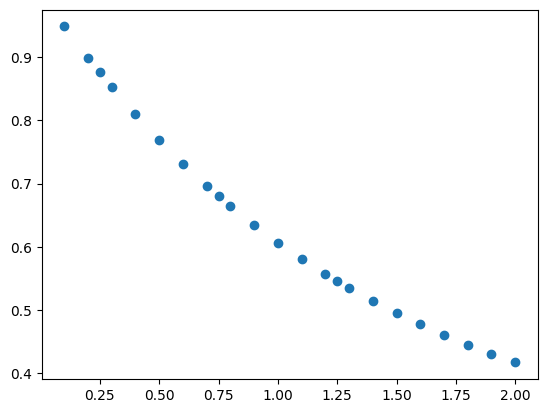

In [24]:
# interpolar x, y em uma grade uniforme de z
interp_func = interp.interp1d(z, f, kind='linear', fill_value='extrapolate')

# calcular f(z) para z = 0.1
z_teste = np.array([0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1, 1.1, 1.2, 1.25, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2])
f_teste = interp_func(z_teste)
print('(z, f):', z_teste, f_teste)

plt.scatter(z_teste, f_teste)
plt.show()